# Import Data

In [1]:
import pandas as pd
import numpy as np 

In [2]:
data = pd.read_csv('Data/giaa_data_5y.csv')

In [3]:
data['date_str'] = pd.to_datetime(data['date_str'])

In [4]:
# rename columns
data = data.rename(columns={'date_str': 'date'})

In [5]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,date
0,513.469910,531.808105,508.885315,527.223511,16244660,0.0,0.0,2019-11-13
1,531.808105,536.392639,508.885315,508.885315,17279985,0.0,0.0,2019-11-14
2,508.885315,536.392639,504.300781,536.392639,14703616,0.0,0.0,2019-11-15
3,536.392639,540.977173,522.638977,522.638977,4026892,0.0,0.0,2019-11-18
4,527.223511,536.392639,504.300781,508.885315,20386831,0.0,0.0,2019-11-19


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213 entries, 0 to 1212
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Open          1213 non-null   float64       
 1   High          1213 non-null   float64       
 2   Low           1213 non-null   float64       
 3   Close         1213 non-null   float64       
 4   Volume        1213 non-null   int64         
 5   Dividends     1213 non-null   float64       
 6   Stock Splits  1213 non-null   float64       
 7   date          1213 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 75.9 KB


In [7]:
data.isnull().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
date            0
dtype: int64

# Feature Engineering

In [8]:
data['Dividends'].value_counts()

Dividends
0.0    1213
Name: count, dtype: int64

In [9]:
data['Stock Splits'].value_counts()

Stock Splits
0.0    1213
Name: count, dtype: int64

In [10]:
data.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)

In [11]:
# 1. Menghitung Return Harian
data['return'] = data['Close'].pct_change()
data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))

In [12]:
# 2. Moving Averages
data['ma_5'] = data['Close'].rolling(window=5).mean()
data['ma_10'] = data['Close'].rolling(window=10).mean()
data['ma_20'] = data['Close'].rolling(window=20).mean()

In [13]:
# 3. Exponential Moving Average (EMA)
data['ema_10'] = data['Close'].ewm(span=10, adjust=False).mean()
data['ema_20'] = data['Close'].ewm(span=20, adjust=False).mean()

In [14]:
# 4. Bollinger Bands
data['bollinger_mid'] = data['Close'].rolling(window=20).mean()
data['bollinger_std'] = data['Close'].rolling(window=20).std()
data['bollinger_upper'] = data['bollinger_mid'] + (2 * data['bollinger_std'])
data['bollinger_lower'] = data['bollinger_mid'] - (2 * data['bollinger_std'])

In [15]:
# 10. Penambahan Fitur Waktu
data['day_of_week'] = data['date'].dt.dayofweek  # 0 = Monday, 6 = Sunday
data['month'] = data['date'].dt.month

In [16]:
# Hapus data yang mengandung nilai NaN akibat perhitungan rolling
data = data.dropna().reset_index(drop=True)

In [17]:
data.head()

,Open,High,Low,Close,Volume,date,return,log_return,ma_5,ma_10,ma_20,ema_10,ema_20,bollinger_mid,bollinger_std,bollinger_upper,bollinger_lower,day_of_week,month
0,463.039795,481.378021,458.455261,472.208923,34022949,2019-12-10,0.030000,0.029559,457.538342,467.257596,487.154549,469.416584,482.634525,487.154549,26.478004,540.110557,434.198540,1,12
1,472.208923,481.378021,458.455261,458.455261,27687871,2019-12-11,-0.029126,-0.029559,457.538342,463.589954,483.716136,467.423616,480.331738,483.716136,25.445797,534.607730,432.824542,2,12
2,458.455261,472.208923,458.455261,458.455261,9238197,2019-12-12,0.000000,0.000000,458.271875,463.589954,481.194633,465.793006,478.248264,481.194633,25.318755,531.832144,430.557123,3,12
3,458.455261,467.624359,454.787598,456.621429,23349061,2019-12-13,-0.004000,-0.004008,460.839227,463.773337,477.206073,464.125447,476.188566,477.206073,22.264674,521.735420,432.676726,4,12
4,458.455261,467.624359,456.621429,463.039795,15549827,2019-12-16,0.014056,0.013958,461.756134,460.564148,474.226114,463.928056,474.936302,474.226114,19.705102,513.636317,434.815910,0,12


In [18]:
data.isnull().sum()

Open               0
High               0
Low                0
Close              0
Volume             0
date               0
return             0
log_return         0
ma_5               0
ma_10              0
ma_20              0
ema_10             0
ema_20             0
bollinger_mid      0
bollinger_std      0
bollinger_upper    0
bollinger_lower    0
day_of_week        0
month              0
dtype: int64

# Modelling

## Preprocessing

In [19]:
dataUsed = data[['Close', 'Volume', 'ma_5', 'ma_10', 'ema_10', 'bollinger_mid', 'bollinger_std', 'bollinger_upper', 'bollinger_lower', 'day_of_week', 'month']]


In [20]:
from sklearn.preprocessing import MinMaxScaler

# preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(dataUsed)

data_scaled

array([[1.        , 0.02039823, 0.98975658, ..., 0.96877591, 0.25      ,
        1.        ],
       [0.96742451, 0.01660008, 0.98975658, ..., 0.96536468, 0.5       ,
        1.        ],
       [0.96742451, 0.0055387 , 0.99153805, ..., 0.95973535, 0.75      ,
        1.        ],
       ...,
       [0.01894797, 0.00590928, 0.01505746, ..., 0.02400798, 0.        ,
        0.90909091],
       [0.01894797, 0.00597139, 0.01651463, ..., 0.0234786 , 0.25      ,
        0.90909091],
       [0.02131646, 0.00722006, 0.01845753, ..., 0.02321517, 0.5       ,
        0.90909091]])

## Train Test Sequence

In [21]:
import numpy as np

sequence_length = 60
x = []
y = []

# Target tetap kolom 0 (harga close), tetapi kita hanya menggunakan kolom lain sebagai input
for i in range(sequence_length, len(data_scaled)):
    x.append(data_scaled[i-sequence_length:i, 1:])  
    y.append(data_scaled[i, 0]) 

# Konversi ke array numpy
x, y = np.array(x), np.array(y)


In [22]:
print(x.shape, y.shape)

(1134, 60, 10) (1134,)


## LSTM

In [23]:
from sklearn.model_selection import train_test_split

# train and test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [25]:
from keras.models import load_model

model = load_model('Model/lstm_model_bbni.h5')

In [26]:
x_train.shape

(907, 60, 10)

In [27]:
# prediction
predicted_prices =  model.predict(x_test)


8/8 [==============================] - 1s 10ms/step


In [28]:
# Dapatkan jumlah kolom yang diharapkan oleh scaler
expected_columns = scaler.min_.shape[0]  # Ini adalah 13 dalam kasus Anda

# Tambahkan kolom nol untuk menyesuaikan jumlah kolom
predicted_prices_padded = np.hstack([np.zeros((predicted_prices.shape[0], expected_columns - 1)), predicted_prices])

# Inverse transform dan ambil hanya kolom harga 'Close'
predicted_prices = scaler.inverse_transform(predicted_prices_padded)[:, -1]  # Ambil hanya kolom harga


In [29]:
expected_columns = scaler.min_.shape[0]  # Ini adalah 13 dalam kasus Anda

# Tambahkan kolom nol untuk menyesuaikan jumlah kolom
real_prices_padded = np.hstack([np.zeros((y_test.shape[0], expected_columns - 1)), y_test.reshape(-1,1)])

# Inverse transform dan ambil hanya kolom harga 'Close'
real_prices = scaler.inverse_transform(real_prices_padded)[:, -1]  # Ambil hanya kolom harga


In [30]:
real_prices

array([ 1.49501559,  1.96397773,  5.0006154 ,  5.0006154 ,  1.78160357,
        5.95616241,  5.0006154 ,  6.29060436,  1.23448107,  1.46896214,
        1.41685524,  5.90838516,  5.0006154 ,  1.36474833,  1.6513363 ,
        1.85976392,  2.25056571,  1.36474833,  1.70344321,  5.0006154 ,
        5.71727576,  6.24282671,  1.41685524,  5.47838871,  5.47838871,
        5.2872793 ,  7.58059333,  6.72060042,  7.43726118,  5.23950205,
        5.71727576,  5.0006154 ,  2.06819154,  5.0006154 ,  1.80765702,
        4.66617345,  1.52106904,  1.26053452,  5.0006154 ,  5.0006154 ,
        7.53281568,  5.0006154 ,  1.99003118, 10.11279361,  2.04213809,
        1.33869488,  5.86060791,  5.0006154 ,  1.        ,  2.25056571,
        5.0006154 ,  5.0006154 , 10.0172391 ,  5.0006154 ,  1.33869488,
        6.05171731,  1.39080178,  1.28658797,  9.6350203 ,  5.0006154 ,
        2.09424499,  1.07816036,  5.2872793 ,  5.0006154 ,  1.20842762,
        1.28658797,  5.0006154 ,  5.0006154 ,  5.0006154 ,  5.00

# Evaluation

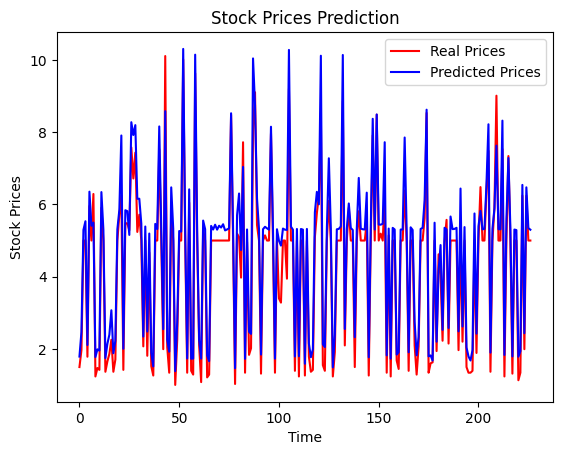

In [31]:
# conpare real and predicted prices
import matplotlib.pyplot as plt

plt.plot(real_prices, color='red', label='Real Prices')
plt.plot(predicted_prices, color='blue', label='Predicted Prices')
plt.title('Stock Prices Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Prices')
plt.legend()
plt.show()

In [32]:
# print real and predicted prices and difference
print('Real Prices: ', real_prices)
print('Predicted Prices: ', predicted_prices)
print('Difference: ', real_prices - predicted_prices)

Real Prices:  [ 1.49501559  1.96397773  5.0006154   5.0006154   1.78160357  5.95616241
  5.0006154   6.29060436  1.23448107  1.46896214  1.41685524  5.90838516
  5.0006154   1.36474833  1.6513363   1.85976392  2.25056571  1.36474833
  1.70344321  5.0006154   5.71727576  6.24282671  1.41685524  5.47838871
  5.47838871  5.2872793   7.58059333  6.72060042  7.43726118  5.23950205
  5.71727576  5.0006154   2.06819154  5.0006154   1.80765702  4.66617345
  1.52106904  1.26053452  5.0006154   5.0006154   7.53281568  5.0006154
  1.99003118 10.11279361  2.04213809  1.33869488  5.86060791  5.0006154
  1.          2.25056571  5.0006154   5.0006154  10.0172391   5.0006154
  1.33869488  6.05171731  1.39080178  1.28658797  9.6350203   5.0006154
  2.09424499  1.07816036  5.2872793   5.0006154   1.20842762  1.28658797
  5.0006154   5.0006154   5.0006154   5.0006154   5.0006154   5.0006154
  5.0006154   5.0006154   5.0006154   5.0006154   8.48836309  5.000615
  1.02605345  5.1917248   5.0961699   3.9734

In [33]:
# calculate RMSE
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(real_prices, predicted_prices))
rmse

0.5746396549297818

In [34]:
# calculate MAE
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(real_prices, predicted_prices)
mae

0.4807924794109111

Directional Accuracy adalah metrik yang digunakan untuk mengukur seberapa baik model memprediksi arah perubahan harga (naik atau turun) dibandingkan dengan nilai aktual. Ini adalah metrik yang sangat berguna dalam prediksi saham karena dalam banyak kasus, arah perubahan harga lebih penting daripada nilai absolut dari harga itu sendiri—terutama jika tujuannya adalah untuk membuat keputusan beli atau jual.

In [35]:
# direction accuracy
direction_accuracy = np.mean(np.sign(real_prices[1:] - real_prices[:-1]) == np.sign(predicted_prices[1:] - predicted_prices[:-1]))
direction_accuracy

0.8008849557522124